In [3]:
# import the library that will be use in the project
import pandas as pd
import duckdb as db
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [4]:
# read the csv file using pandas
data = pd.read_csv('ecommerce_data.csv')
dataframe = pd.DataFrame(data)
dataframe.head()

,Order_ID,Customer_ID,Product_ID,Product_Name,Category,Price,Quantity,Order_Date,Delivery_Date,Payment_Method
0,48ca9641-6d4c-4f39-b2e9-bf2e64eb97d8,76c18b23-a7d5-4b66-adaa-7aa143af36be,e19cbae9-8203-46ab-a8c8-5933dd0078ba,in,recognize,164.29,6.0,2020-08-26,2020-08-26,Credit Card
1,5ece9c62-f8d7-40eb-9a02-4ea7de0f1c6a,180f5718-28ca-4a35-adea-b74b05da3b08,932a13e1-2c6f-4f64-b644-6e9ae6cef485,list,mission,614.45,9.0,NaN,NaN,PayPal
2,NaN,a48c729f-374a-4a46-ae22-65d691fdcca2,896de70f-ab14-4d12-a6e0-8c3cdddd8c74,society,NaN,377.48,1.0,2020-02-21,2020-02-24,Credit Card
3,NaN,6a8965d2-f002-49ab-bfa3-4412e029fb5e,19fa7a20-d5e4-410f-bd51-b31899fd200e,themselves,or,NaN,1.0,2022-04-09,2022-04-13,Cash
4,d7493946-0d19-4c0e-a037-a985061a6f4f,0e6831fc-a7a4-41b4-b861-41f747702832,4202bb8b-63c1-4b59-8228-96a1d6a6efe2,those,marriage,NaN,1.0,2021-02-12,2021-02-21,Cash


In [5]:
[data.shape[0], data.shape[1]]

[1000, 10]

In [6]:
# make a function for duckdb so that we can execute the query more effective
def query(sql_query):
    return db.sql(sql_query).df()

### 1. Rata-rata harga produk yang terjual

In [7]:
# drop the null value so that we can get more accurate result
new_price = dataframe['Price'].dropna()
print(f"Rata-rata harga produk yang terjual: {new_price.mean():.2f}")

Rata-rata harga produk yang terjual: 522.43


### 2. Total produk yang terjual dengan jumlah penjualan tertinggi

In [8]:
total_products = query(
    """
    SELECT
        Quantity,
        COUNT(Product_ID) as total_products
    FROM dataframe
    GROUP BY 1
    ORDER BY 1 DESC
    """
)
total_products

,Quantity,total_products
0,10.0,79
1,9.0,98
2,8.0,64
3,7.0,81
4,6.0,74
5,5.0,85
6,4.0,82
7,3.0,86
8,2.0,85
9,1.0,91


Berdasarkan data tersebut, dapat terlihat bahwa total produk yang terjual dengan jumlah penjualan tertinggi adalah 79 produk

### 3. Kategori produk yang memiliki rata-rata harga tertinggi

In [9]:
# select a specific column from the database and copy 
max_price = dataframe[['Category','Price']].copy()

# drop the null value so that we can get the accurate result
max_price.dropna(inplace=True)

# sort the data from the max to the min
max_price.sort_values(by='Price', ascending=False)

,Category,Price
998,myself,999.34
904,require,998.62
403,move,998.56
140,eight,994.30
772,moment,992.76
...,...,...
114,describe,13.80
962,bar,12.61
256,move,11.71
755,future,11.05


Berdasarkan output yang dihasilkan dapat diketahui bahwa kategori produk yang memiliki rata-rata harga tertinggi yaitu myself dengan harga 999.34

### 4. Tren penjualan dari bulan ke bulan ***(monthly sales)***

In [10]:
# make a new data and convert to dataframe
order_date = pd.DataFrame(dataframe[['Order_Date','Quantity','Price']])

# change the data type to datetime
order_date['Order_Date'] = pd.to_datetime(order_date['Order_Date'])

# drop the null value
order_date.dropna(inplace=True)
order_date

,Order_Date,Quantity,Price
0,2020-08-26,6.0,164.29
2,2020-02-21,1.0,377.48
6,2021-11-12,2.0,881.79
8,2022-02-21,9.0,136.01
9,2021-10-03,7.0,962.10
...,...,...,...
995,2020-10-26,7.0,26.10
996,2021-05-06,3.0,661.73
997,2021-03-07,1.0,74.94
998,2020-06-08,1.0,999.34


In [11]:
# make query that take only the month in every year
# and count the total sales using quantity and price
monthly_sales = query(
    """
    WITH SALES AS(
        SELECT
            DATE_TRUNC('month', Order_Date) as year_month,
            SUM(Quantity * Price) as total_sales
        FROM order_date
        GROUP BY 1
        ORDER BY 1,2
    ),
    PREVIOUS AS(
        SELECT *,
            LAG(total_sales, 1) OVER(ORDER BY year_month) as previous_total_sales
        FROM SALES
        ORDER BY year_month
    ),
    RESULT AS(
        SELECT *,
            CASE WHEN
                previous_total_sales is not null THEN
                CONCAT(ROUND((total_sales - previous_total_sales)/previous_total_sales * 100, 2),'%')
                ELSE NULL END AS total_sales_growth
        FROM PREVIOUS
    )
    SELECT * FROM RESULT
    """
)
monthly_sales.head()

,year_month,total_sales,previous_total_sales,total_sales_growth
0,2020-01-01,52580.82,NaN,None
1,2020-02-01,26759.50,52580.82,-49.11%
2,2020-03-01,69833.80,26759.50,160.97%
3,2020-04-01,61643.96,69833.80,-11.73%
4,2020-05-01,28382.10,61643.96,-53.96%


Text(0, 0.5, 'Total Sales')

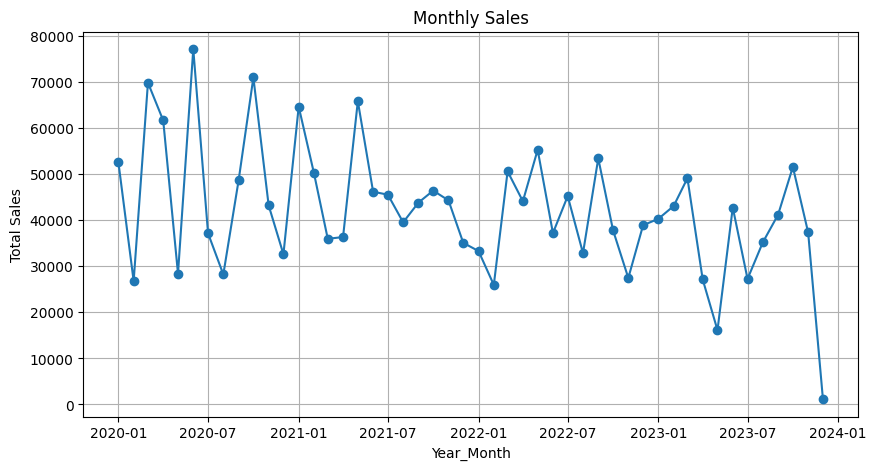

In [12]:
# make a line graph so we can get the monthly sales result
plt.figure(figsize=(10,5))
plt.plot(monthly_sales['year_month'], monthly_sales['total_sales'], marker='o')
plt.grid(True)
plt.title('Monthly Sales')
plt.xlabel('Year_Month')
plt.ylabel('Total Sales')

Dari hasil tersebut dapat diketahui bahwa terdapat fluktuasi yang cukup tinggi pada total penjualan setiap bulannya, terutama pada bulan-bulan awal penjulalan itu terjadi. Pada pertengahan tahun, terjadi penjualan yang cukup stabil pada beberapa bulan yang diikuti dengan fluktuasi sedang, hingga di tahun terakhir penjualan, terdapat fluktuasi yang cukup besar dan ditutup dengan total penjualan yang merosot tajam hingga menyentuh angka terendah dari keseluruhan data yang ada.

### 5. Mendeteksi pola penjualan satu minggu terakhir

In [13]:
# make a new dataframe
costumer_spend = dataframe[['Order_Date','Price','Quantity']].copy()

# drop the null value
costumer_spend.dropna(inplace=True)

# change the data type to datetime
costumer_spend['Order_Date'] = pd.to_datetime(costumer_spend['Order_Date'])

In [14]:
# make query so that we can get the weekly_sales result
weekly_sales = query(
    """
    WITH COUNT AS(
        SELECT
            Order_Date,
            SUM(Price * Quantity) as Weekly_Sales
        FROM costumer_spend WHERE Order_Date BETWEEN '2023-11-17' AND '2023-11-26'
        GROUP BY 1
        ORDER BY Order_Date DESC
    ),
    NEW AS(
        SELECT *,
            LAG(Weekly_Sales, 1) OVER(ORDER BY Order_Date) as previous_weekly_sales
        FROM COUNT
    ),
    FINAL AS(
        SELECT *,
            CASE WHEN
                previous_weekly_sales is not null THEN
                CONCAT(ROUND((Weekly_Sales - previous_weekly_sales)/previous_weekly_sales * 100, 2),'%')
                ELSE NULL END AS weekly_sales_growth
        FROM NEW
    )
    SELECT * FROM FINAL
    """
)
weekly_sales

,Order_Date,Weekly_Sales,previous_weekly_sales,weekly_sales_growth
0,2023-11-17,4140.81,NaN,None
1,2023-11-18,810.95,4140.81,-80.42%
2,2023-11-19,1009.24,810.95,24.45%
3,2023-11-21,6366.00,1009.24,530.77%
4,2023-11-23,3448.13,6366.00,-45.84%
5,2023-11-26,5735.73,3448.13,66.34%


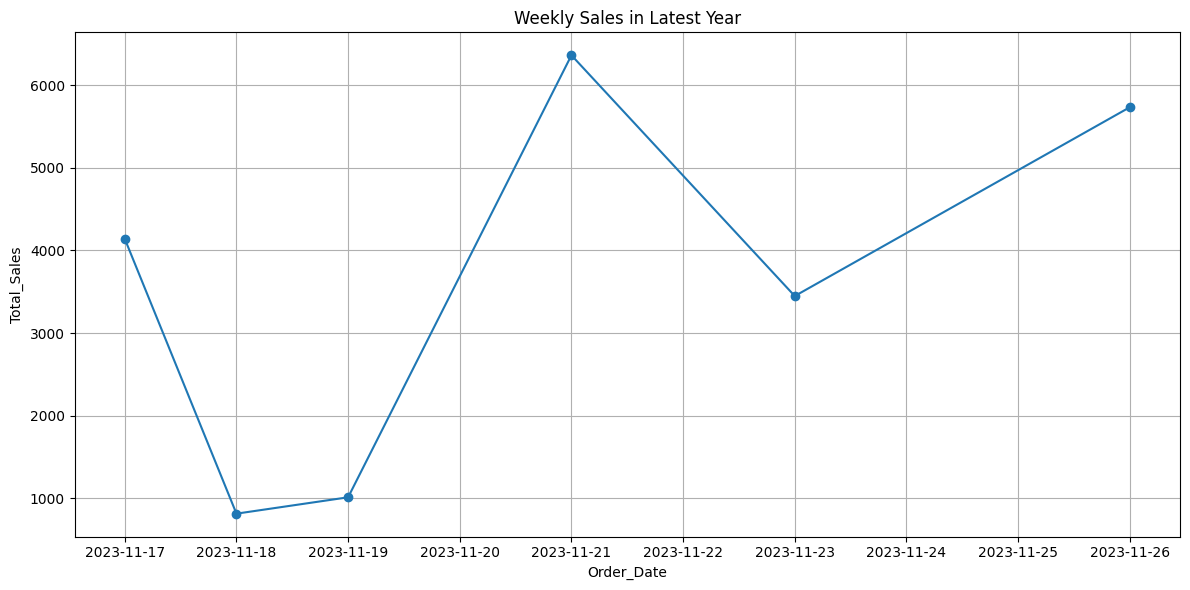

In [15]:
# make a graph of latest weekly sales
plt.figure(figsize=(12,6))
plt.plot(weekly_sales['Order_Date'], weekly_sales['Weekly_Sales'], marker='o')
plt.title('Weekly Sales in Latest Year')
# plt.xticks(rotation=45)
plt.xlabel('Order_Date')
plt.ylabel('Total_Sales')
plt.tight_layout()
plt.grid(True)

Berdasarkan grafik tersebut, dapat terlihat bahwa terdapat pola data yang cukup menarik pada hari-hari tertentu dalam minggu terakhir penjualan. Pada awalnya, penjualan mengalami penurunan tajam, tapi pada tanggal 21, terjadi lonjakan penjualan yang sangat signifikan hingga 5 kali lipat/500% dan menyentuh angka tertinggi dalam satu minggu terakhir. Dengan kenaikan yang sangat drastis tersebut, tentu dapat kita katakan bahwa pola penjualan tersebut cukup unik sehingga kedepannya kita dapat mencari tahu penyebabnya dengan harapan kita dapat mengimplementasikannya kembali di kemudian hari.

### 6. Top five customer total purchase distribution

In [16]:
# select data that we need and drop the null value
select_data = dataframe[['Order_Date','Customer_ID','Price','Quantity']].copy()
select_data['Order_Date'] = pd.to_datetime(select_data['Order_Date'])
select_data.dropna(inplace=True)

In [17]:
# make a query that count the total purchase
customer_purchase = query(
    """
    WITH TOTAL AS(
        SELECT
            Customer_ID,
            EXTRACT(Year FROM Order_Date) as year,
            SUM(Price * Quantity) as total_purchase
        FROM select_data
        GROUP BY 1,2
        ORDER BY 3 DESC
    ),
    RANK AS(
        SELECT *,
            ROW_NUMBER() OVER(PARTITION BY year ORDER BY(year)) as ranking
        FROM TOTAL
        ORDER BY year DESC
    )
    SELECT * FROM RANK WHERE ranking <= 5
    """
)
customer_purchase

,Customer_ID,year,total_purchase,ranking
0,6d388e4f-e0c1-4f59-ba32-d12914e5fd0b,2023,8905.77,1
1,775bc6a7-225f-4b34-bc6c-06d73106b528,2023,8243.20,2
2,11084415-6db2-4009-a191-592dbd3453ca,2023,8052.00,3
3,d47d1e9f-3138-4dd0-886b-12cb356cca9b,2023,8011.26,4
4,07219263-e3a9-458e-a026-0d3af4d9771a,2023,7988.96,5
5,52b42879-f424-483d-b02c-5bb48d2a5d6c,2022,9727.20,1
6,24cf60a8-4f50-4f7c-b990-aee8cf08e011,2022,8745.10,2
7,24cf5dba-30fc-469b-a0c6-15a6547f5aca,2022,8347.10,3
8,bd786429-cef2-4305-80bb-e3891b0c2dfa,2022,8103.51,4
9,640eaf71-bd1c-4233-983a-b57b33dc3de1,2022,7635.42,5


Dari insight yang diperoleh dapat diketahui bahwa distribusi pembelian per pelanggan di setiap tahunnya dapat dikatakan mengalami distribusi yang normal karena jarak atau rentang antar nilai nya tidak terlalu jauh. Selain itu, karena jumlah customer yang cukup besar maka saya mengambil top 5 konsumen dengan total belanja tertinggi untuk melihat siapa saja konsumen tersebut yang kemudian nantinya insight ini dapat kita gunakan untuk memberikan suatu rekomendasi kepada para customer tersebut agar mereka dapat selalu loyal terhadap produk kita.

### 7. Mencari tahu berapa konsumen yang melakukan pembelian ulang ***(repeat order)***

Berdasarkan hasil analisa di nomor sebelumnya, dapat diketahui bahwa tidak terdapat customer yang melakukan pembelian kedua dan seterusnya (repeat order) baik itu di tahun 2020, 2021, 2022, maupun 2023. Karena itulah dengan mengetahui top 5 customer tersebut, kita tentu dapat menggunakan data itu untuk melakukan pendekatan khusus seperti diskon, buy 1 get 1, dll kepada para customer yang melakukan pembelian terbesar dengan harapan pada tahun berikutnya mereka akan berbelanja kembali bahkan menjadi pelanggan yang loyal terhadap produk kita.

### 8. Metode Pembayaran yang paling sering digunakan

In [18]:
payment_method = pd.DataFrame(dataframe['Payment_Method'].value_counts())
print(f"Metode pembayaran yang paling sering digunakan adalah cash dengan total {payment_method['count'].iloc[0]} customer")

Metode pembayaran yang paling sering digunakan adalah cash dengan total 310 customer


### 9. Finding the correlation between payment method and customer total spending

In [19]:
# make a new dataset that contain column we need to analyze
# and drop the null value
corr = dataframe[['Payment_Method', 'Quantity','Price']].copy()
corr.dropna(inplace=True)

correlations = query(
    """
    SELECT
        Payment_Method,
        SUM(Quantity * Price) as total_spend
    FROM corr
    GROUP BY 1
    ORDER BY 2 DESC
    """
)
correlations

,Payment_Method,total_spend
0,Credit Card,753343.04
1,Cash,665528.44
2,PayPal,614619.74


In [20]:
# import sklearn library
from sklearn.preprocessing import LabelEncoder

# transform the payment method column from categorical to numerical data
encoder = LabelEncoder()
numerical_data = encoder.fit_transform(correlations['Payment_Method'])

# make a variable to make it easier to use and change the array dimension using flatten 
x1 = numerical_data
x2 = correlations['total_spend'].values.flatten()

# rank the x2 values so that the correlation value can be more accurate
ranking = np.argsort(x2)

# finding the correlation between the two variable
correlation_result = np.corrcoef(x1, ranking, rowvar=False)
correlation_result

array([[ 1. , -0.5],
       [-0.5,  1. ]])

Berdasarkan hasil tersebut, dapat diketahui bahwa terdapat korelasi sedang antara metode pembayaran dan total pembelian yang artinya keterkaitan antara keduanya tidak lemah tapi juga tidak kuat. Hal ini didasarkan oleh nilai korelasi sebesar 0,5 dimana jika nilai korelasi semakin mendekati 1, maka korelasi nya semakin kuat dan begitu pula sebaliknya. Tanda negatif menandakan bahwa semakin tinggi total pembelian maka semakin rendah nilai dari metode pembayaran (dalam bentuk numerical) yang digunakan dan begitu pula sebaliknya. Akan tetapi, perhitungan korelasi ini dapat dikatakan masih belum akurat. Hal ini disebabkan karena data pada kedua variabel terbilang sangat sedikit sehingga tidak mampu menjelaskan keterkaitan atau korelasi secara lebih detail dan mendalam.

### 10. Mencari presentase pesanan yang mengalami keterlamabatan

In [25]:
date = dataframe[['Order_Date','Delivery_Date']].copy()

for x in date:
    dataframe[x] = pd.to_datetime(dataframe[x])

date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order_Date     908 non-null    datetime64[ns]
 1   Delivery_Date  807 non-null    datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 15.8 KB


In [26]:
date.isnull().sum()

Order_Date        92
Delivery_Date    193
dtype: int64

In [27]:
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order_Date     908 non-null    datetime64[ns]
 1   Delivery_Date  807 non-null    datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 15.8 KB


In [28]:
date['delay'] = date['Delivery_Date'] - date['Order_Date']
new_date = date.dropna()
delayed_orders = new_date[new_date['delay'] > pd.Timedelta(days=3)]
precentage = (len(delayed_orders) / len(date)) * 100
print(f"Persentase pesanan yang mengalami keterlambatan pengiriman yaitu sebesar {precentage} persen")

Persentase pesanan yang mengalami keterlambatan pengiriman yaitu sebesar 49.3 persen


Berdasarkan presentase pesanan tersebut, dapat kita simpulkan bahwa hampir setengah dari total pesanan mengalami keterlambatan. Hal ini tentu merupakan masalah yang cukup serius dan mampu memberikan efek yang buruk bagi keberlangsungan dari bisnis ini. Oleh karena itu, diperlukan analisa lebih dalam terkait apa sebenarnya yang menjadi faktor penyebab dari banyaknya keterlambatan yang terjadi dengan harapan kedepannya performa bisnis akan menjadi jauh lebih baik.

### 11. Apakah terdapat pola keterlambatan pengiriman berdasarkan kategori produk jika dibeli lebih dari dua kali?

In [29]:
# drop the null value
data_value = dataframe[['Order_Date','Delivery_Date','Category']].dropna().copy()

# finding the delays value
data_value['delays'] = data_value['Delivery_Date'] - data_value['Order_Date']

# filtering so the result focused on more than 3 days delays
result = data_value[data_value['delays'] > pd.Timedelta(days=3)]

# finding the total order base on category
final = result['Category'].value_counts().reset_index()
final.rename(columns={'count':'Total_Order'}, inplace=True)
final

,Category,Total_Order
0,move,4
1,me,3
2,describe,3
3,dinner,3
4,stay,3
...,...,...
346,war,1
347,marriage,1
348,newspaper,1
349,worry,1


In [30]:
# find the average delays based on product category
new_value = query(
    """
    SELECT
        Category,
        AVG(EXTRACT(Day From delays)) as average_delays
    FROM result
    GROUP BY 1
    ORDER BY 2 DESC
    """
)
new_value

,Category,average_delays
0,marriage,9.0
1,spend,9.0
2,federal,9.0
3,within,9.0
4,soldier,9.0
...,...,...
346,industry,4.0
347,senior,4.0
348,if,4.0
349,contain,4.0


In [31]:
# combine average delays and total order column
final_data = query(
    """
    WITH COMBINE AS(
        SELECT
            final.Category, final.Total_Order,
            new_value.average_delays
        FROM final INNER JOIN new_value ON
        final.Category = new_value.Category
    ),
    FINAL_RESULT AS(
        SELECT
            Category,
            Total_Order,
            ROUND(average_delays,0) as average_delays
        FROM COMBINE WHERE Total_Order > 2
        ORDER BY 2 DESC
    )
    SELECT * FROM FINAL_RESULT
    """
)
final_data

,Category,Total_Order,average_delays
0,move,4,7.0
1,stay,3,8.0
2,single,3,8.0
3,me,3,8.0
4,finish,3,7.0
5,describe,3,7.0
6,citizen,3,7.0
7,quality,3,6.0
8,dinner,3,5.0
9,every,3,5.0


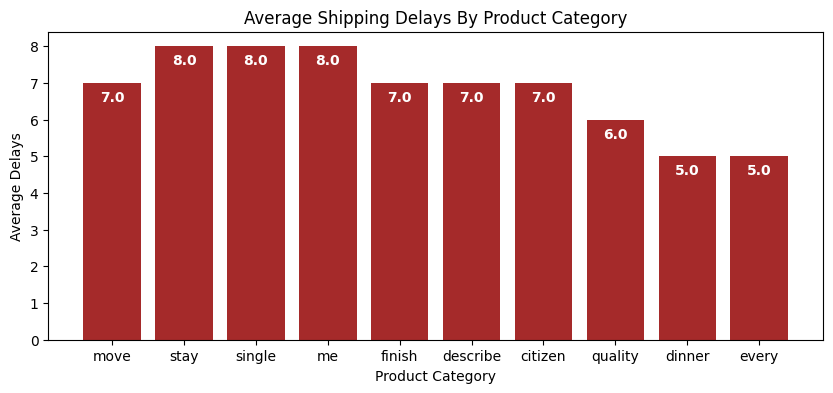

In [32]:
# make a visualization using matplotlib
plt.figure(figsize=(10,4))
plt.title("Average Shipping Delays By Product Category")
plt.bar(final_data['Category'], final_data['average_delays'], color='brown')
plt.xlabel("Product Category")
plt.ylabel("Average Delays")

for i, v in enumerate(final_data['average_delays']):
    plt.text(i, v-0.5, v, ha='center', color='white', weight='bold')

In [33]:
# Plotting with Plotly
fig = px.bar(final_data, x='Category', y='average_delays',
             title='Average Shipping Delays by Product Category',
             labels={'delays': 'Average Delay', 'product_category': 'Product Category'})
fig.update_yaxes(title_text='Average Delay')  # Update y-axis title

fig.show()

Berdasarkan analisis yang dilakukan terlihat adanya pola keterlambatan yang terjadi berdasarkan kategori produk. Kedua grafik batang di atas menunjukkan adanya pola naik turun yang cukup konsisten pada setiap kategori produk yang dibeli lebih dari dua kali selama penjualan.

Kategori produk yang mengalami rata-rata keterlambatan paling lama adalah ***stay, single*** dan ***me*** dengan rata-rata keterlambatan 8 hari, disusul ***move, finish, describe*** dan ***citizen*** dengan rata-rata keterlambatan 7 hari, ***quality*** dengan rata-rata keterlambatan 6 hari, juga ***dinner*** dan ***every*** dengan keterlambatan rata-rata 5 hari.